# Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

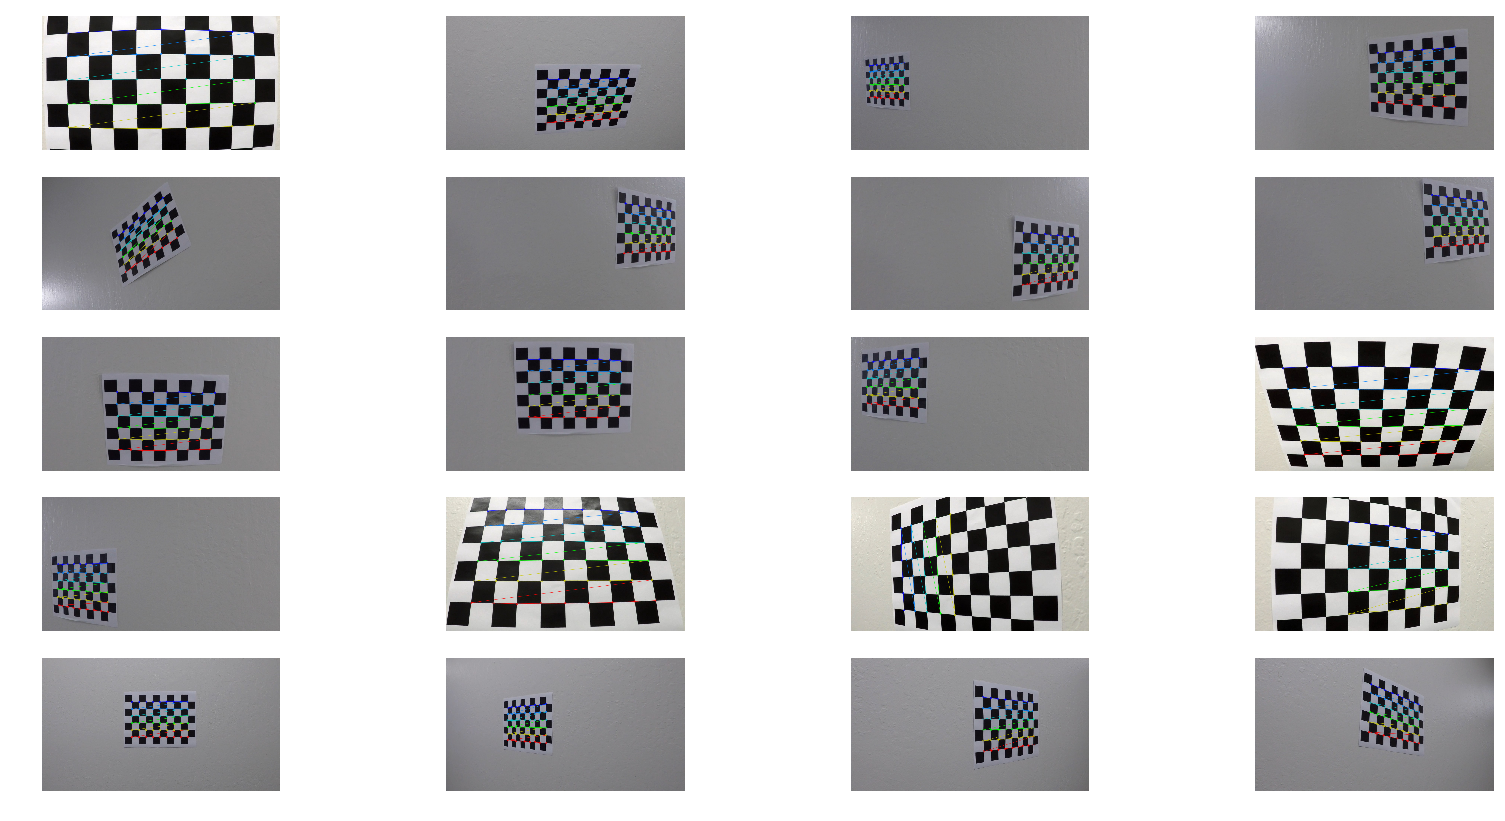

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
def get_object_points(size):
    objp = np.zeros((size[0]*size[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:size[0],0:size[1]].T.reshape(-1,2)
    return objp

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# prepare pattern size
pattern_sizes = [(9,6),(9,5),(6,5),(7,5)]

# Step through the list and search for chessboard corners
i = 1
plt.figure(figsize=(20, 10))
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    for size in pattern_sizes:
        ret, corners = cv2.findChessboardCorners(gray, size, None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(get_object_points(size))
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, size, corners, ret)
            plt.subplot(5, 4, i)
            plt.axis('off')
            plt.imshow(img)
            i+=1
            break

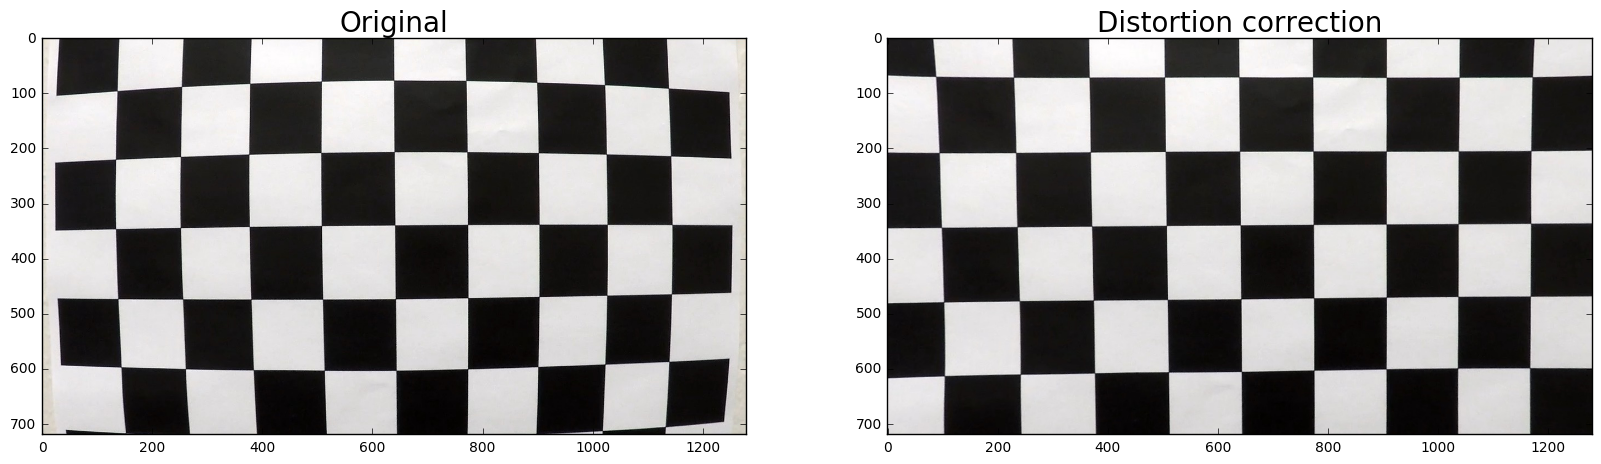

In [3]:
# Test image
img = mpimg.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Distortion correction', fontsize=20)

In [4]:
# Save the matrix and distortion coefficients
import pickle

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open( "camera_dist_pickle.p", "wb"))

# Image Pipeline

In [5]:
# Load pickled matrix and distortion coefficients
import pickle

with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

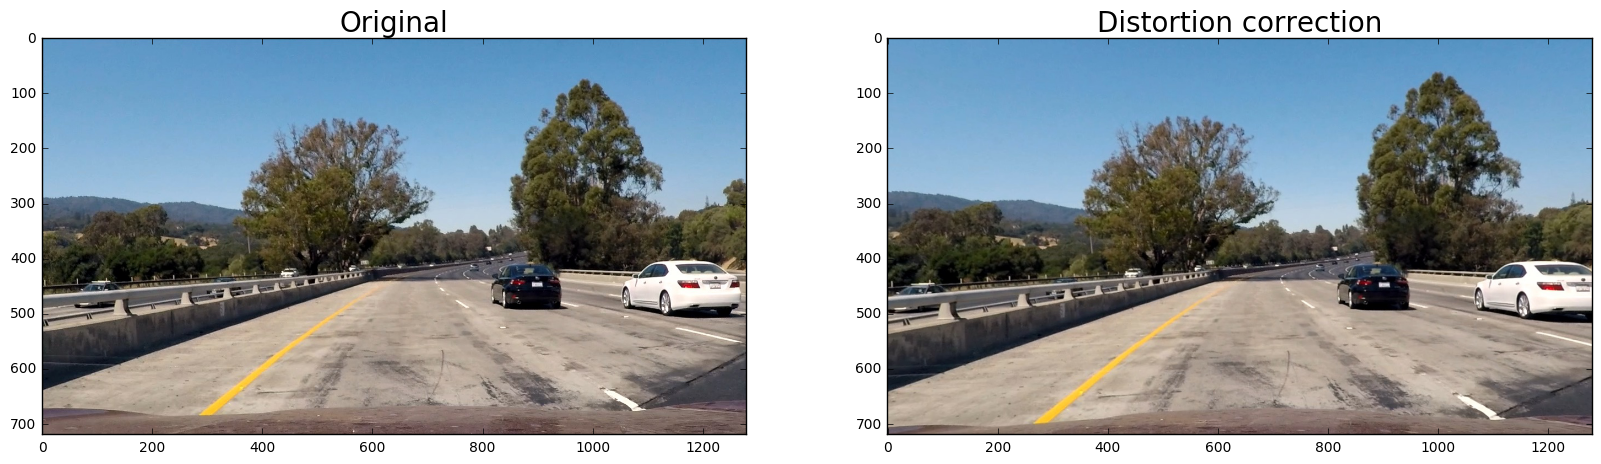

In [6]:
# Undistortion Test
test_img = mpimg.imread('test_images/test1.jpg')
undist_img = cv2.undistort(test_img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original', fontsize=20)
ax2.imshow(undist_img)
ax2.set_title('Distortion correction', fontsize=20)

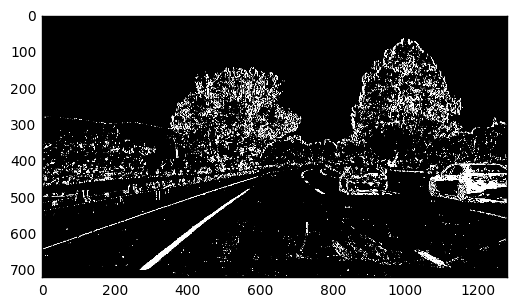

In [7]:
def thresholding(img, sx_thresh=(20, 100), s_thresh=(170, 255)):
    # Convert to HLS color space and separate channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

plt.imshow(thresholding(undist_img), cmap='gray')

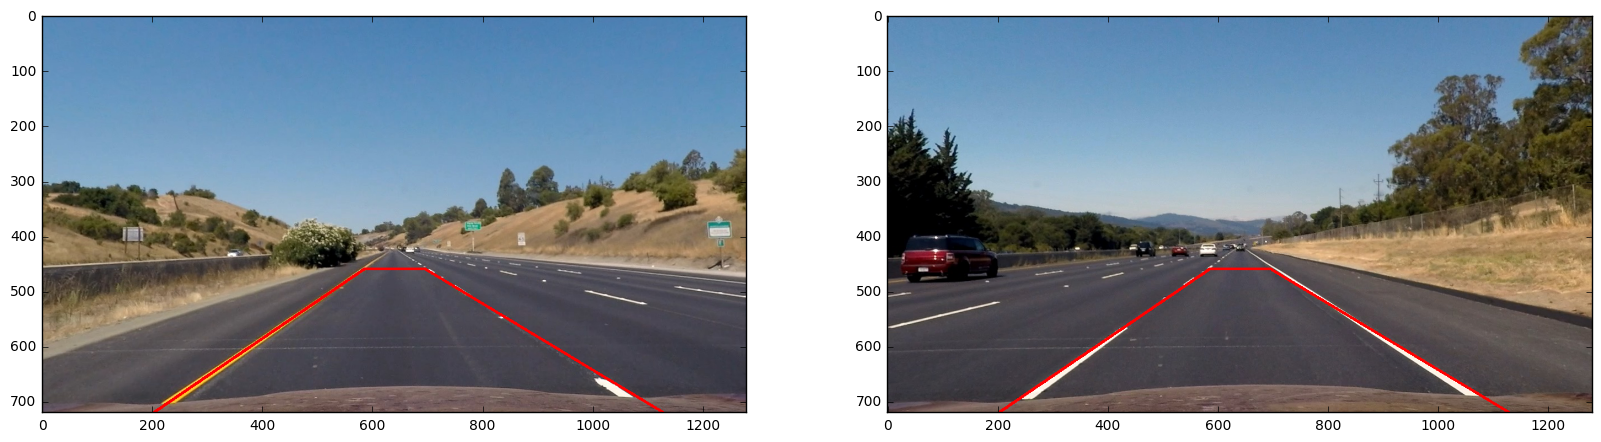

In [8]:
# Draw source points
src = np.float32([[203,720],[585,460],[695,460],[1127,720]])
images = glob.glob('test_images/straight_lines*.jpg')
result = []
for fname in images:
    img = mpimg.imread(fname)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    for i in range(len(src)-1):
        cv2.line(img, (src[i][0], src[i][1]), (src[i+1][0], src[i+1][1]), color=[255,0,0], thickness=3)
    result.append(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(result[0])
ax2.imshow(result[1])

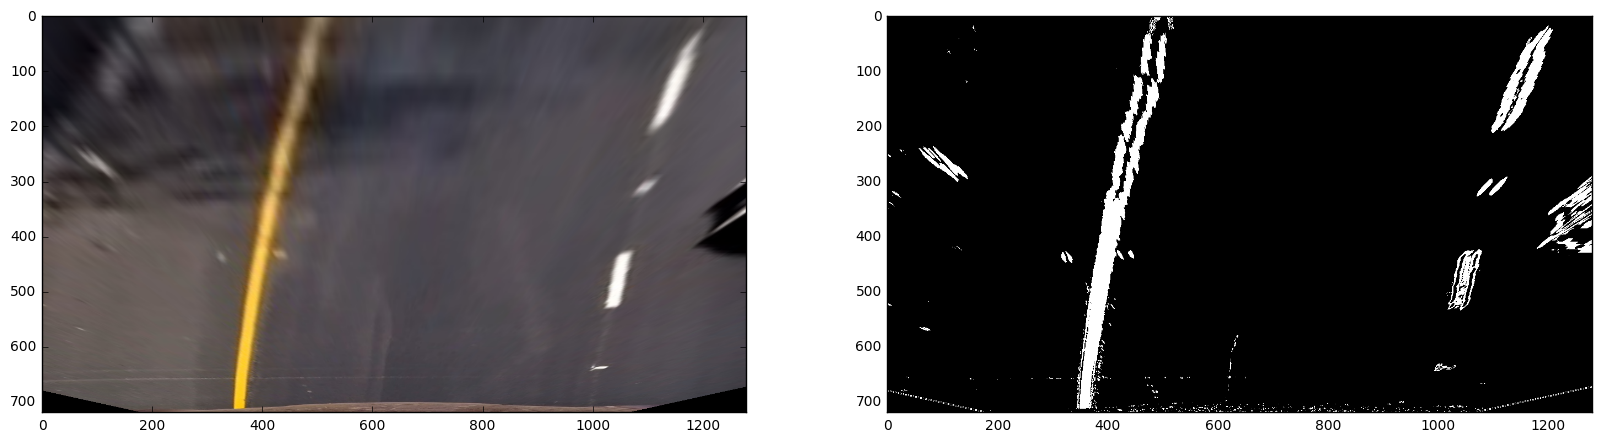

In [9]:
# Perspective Transform
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[203,720],[585,460],[695,460],[1127,720]])
    dst = np.float32([[320,720],[320,0],[960,0],[960,720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return Minv, cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

img = mpimg.imread('test_images/test6.jpg')
undist_img = cv2.undistort(img, mtx, dist, None, mtx)
_, warp_img = warp(undist_img)
thresh_warp = thresholding(warp_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(warp_img)
ax2.imshow(thresh_warp, cmap='gray')

In [10]:
def find_lines(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

In [11]:
def fit_lines(binary_warped, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, left_fitx, right_fitx

In [12]:
def get_curvature(ploty, leftx, lefty, rightx, righty):
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [13]:
def get_position(result, pts_left, pts_right):
    xm_per_pix = 3.7 / 700
    lane_difference = pts_right[0, pts_right[0,:,1].argmax(), 0] - pts_left[0, pts_left[0,:,1].argmax(), 0]
    center_offset = (lane_difference - result.shape[1]/2) * xm_per_pix
    return center_offset

In [14]:
def draw_lines(warped, ploty, left_fitx, right_fitx, Minv, undist, left_curverad, right_curverad):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Put text on an image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Left Curvature: {} m".format(round(left_curverad, 3))
    cv2.putText(result, text, (400, 50), font, 1, (255,255,255), 2)
    text = "Right Curvature: {} m".format(round(right_curverad, 3))
    cv2.putText(result, text, (400, 100), font, 1, (255,255,255), 2)
    position = get_position(result, pts_left, pts_right)
    text = "Distance from center: {} m".format(round(position, 3))
    cv2.putText(result, text,(400,150), font, 1, (255,255,255), 2)
    
    return result

In [15]:
def pipeline(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    Minv, warped = warp(undist)
    binary_warped = thresholding(warped)
    leftx, lefty, rightx, righty = find_lines(binary_warped)
    ploty, left_fitx, right_fitx = fit_lines(binary_warped, leftx, lefty, rightx, righty)
    left_curverad, right_curverad = get_curvature(ploty, leftx, lefty, rightx, righty)
    return draw_lines(binary_warped, ploty, left_fitx, right_fitx, Minv, undist, left_curverad, right_curverad)

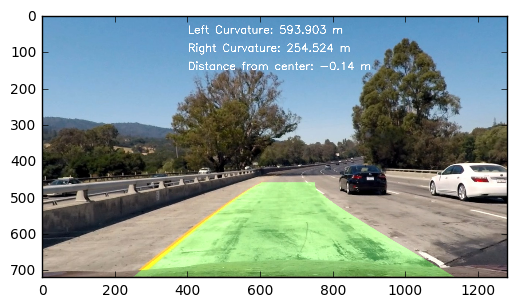

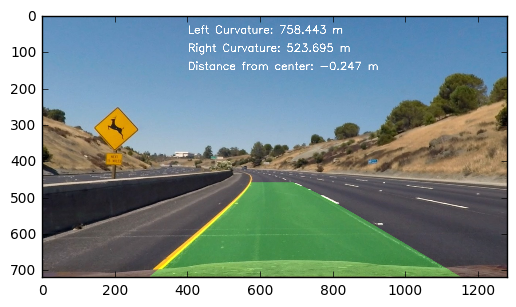

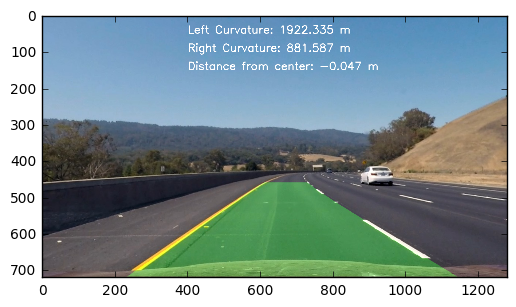

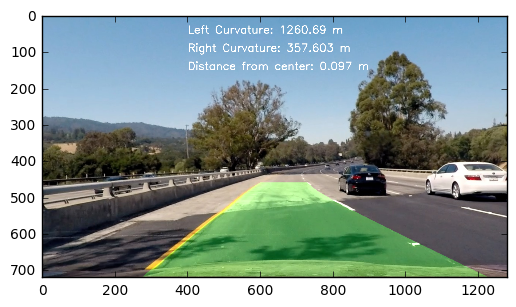

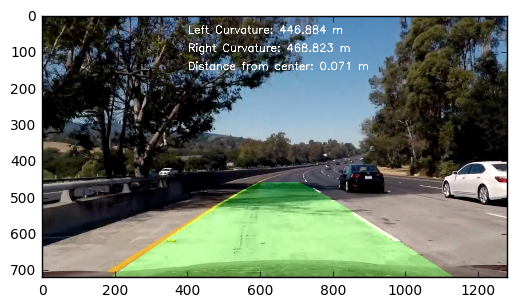

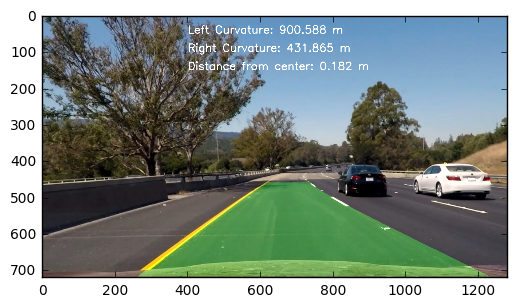

In [16]:
images = glob.glob('test_images/test*.jpg')
for fname in images:
    img = mpimg.imread(fname)
    plt.imshow(pipeline(img, mtx, dist))
    plt.figure()

## Video Pipeline

In [17]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(img):
    return pipeline(img, mtx, dist)

video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:11<00:00,  9.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 7s, sys: 31.8 s, total: 2min 39s
Wall time: 2min 12s
